In [0]:
import h5py
from sklearn.metrics import roc_curve, auc,roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import torch

In [0]:
train_size  = 180000     # Training size
valid_size  = 50000    # Validation size
#test_size   = 10000     # Test size
batch_size = 64

In [30]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


## Load data

In [31]:
#get data from drive
from google.colab import drive
drive.mount('/content/drive')
filepath = "/content/drive/My Drive/lhcmlhackathon-master/notebooks/"

img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File(filepath+'%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = train_size, train_size+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)
'''
# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)
'''
samples_requested = len(decays) * (train_size + valid_size )#+ test_size)
samples_available = len(y_train) + len(y_valid) #+ len(y_test)
assert samples_requested == samples_available

In [33]:
y_train.shape,y_valid.shape

((360000,), (100000,))

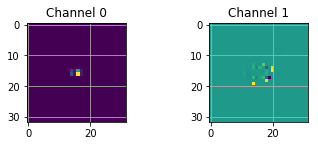

In [34]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[0,:,:,0])
plt.title("Channel 0")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[0,:,:,1])
plt.title("Channel 1")  # Time
plt.grid(True)


plt.show()

In [35]:
X_train.shape,X_valid.shape

((360000, 32, 32, 2), (100000, 32, 32, 2))

In [36]:
y_train

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [37]:
X_train[0].T.shape

(2, 32, 32)

## DataLoader

In [0]:
##### Custom Dataset
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import transforms

In [0]:

class DataTrain(Dataset):
    def __init__(self):
        super(DataTrain, self).__init__()
        ############ Transforms
        #normalize
        #transforms.Normalize((0.5, 0.5), (0.25, 0.25))
        #transforms.CenterCrop(224),
        #torchvision.transforms.RandomHorizontalFlip(),
        #torchvision.transforms.RandomRotation(10),
        

        ############ data
        self.data = torch.Tensor(X_train).float()
        self.labels = torch.Tensor(y_train).long()
        
    def __getitem__(self, index):  #get 1 jet tracks
        ########### input
        image = torch.transpose(self.data[index],0,-1)
  
        ########### label
        data_label = self.labels[index]
        #data_label = data_label.view(1,1) ## each element needs torch.Size = 1
        return image,data_label

    def __len__(self):
        return self.data.shape[0] # number of jets
    
    
class DataValid(Dataset):
    def __init__(self):
        super(DataValid, self).__init__()
        ############ Transforms
        #normalize
        #transforms.Normalize((0.5, 0.5), (0.25, 0.25))
        ############ data
        self.data = torch.Tensor(X_valid).float()
        self.labels = torch.Tensor(y_valid).long()
        
    def __getitem__(self, index):  #get 1 jet tracks
        ########### input
        image = torch.transpose(self.data[index],0,-1)
  
        ########### label
        data_label = self.labels[index]
        #data_label = data_label.view(1,1) ## each element needs torch.Size = 1
        return image,data_label

    def __len__(self):
        return self.data.shape[0] # number of jets

In [0]:
batchSize = 64


In [41]:
from torch.utils.data import DataLoader
DataTrain_ = DataTrain()
DataValid_ = DataValid()

DataTrainLoader = DataLoader(dataset = DataTrain_,batch_size = batchSize ,shuffle = True,drop_last=True, pin_memory = False) #num_workers=4 #number of cpu workers
DataValidLoader = DataLoader(dataset = DataValid_,batch_size = batchSize ,shuffle = True,drop_last=True, pin_memory = False)

print(len(DataTrain_)) #number of jets
len(DataTrainLoader) #number of batches of jets

360000


5625

In [42]:
a = np.array([[[1,2],[2,3],[4,5]]])
b = torch.tensor(a)
b.shape, torch.transpose(b,0,-1).shape

(torch.Size([1, 3, 2]), torch.Size([2, 3, 1]))

## Build network

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [44]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x2 image tensor)
        self.conv1 = nn.Conv2d(2, 16, 2, padding=0)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 2, padding=0)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 2, padding=0)
        # convolutional layer (sees 4x4x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 2, padding=0)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 2 , 500)
        # linear layer (500 -> 2)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,32)
        self.fc6 = nn.Linear(32,16)
        self.fc7 = nn.Linear(16,2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        # flatten image input
        x = x.view(-1, 64 * 2 )
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        #print(x.shape)
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)        
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)        
        x = self.fc7(x)
        return x.reshape(batchSize,x.shape[1])

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(2, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.25)
)


In [0]:
import torch.optim as optim

# specify loss function 
#criterion = nn.NLLLoss()
criterion =nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)

In [46]:
######## first check
# obtain one batch of training set
dataiter = iter(DataTrainLoader)
data_tr,data_l = dataiter.next()

######## Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()
print(data_tr.shape,data_l.shape)

###### move tensors to GPU if CUDA is available
if train_on_gpu:
  data_tr = data_tr.cuda()
  data_l = data_l.cuda()

####### Forward pass, then backward pass, then update weights
output = model(data_tr)
loss = criterion(output, data_l)
loss.backward()
print(torch.softmax(output,1))
print(loss.item())





torch.Size([64, 2, 32, 32]) torch.Size([64])
tensor([[0.6032, 0.3968],
        [0.6030, 0.3970],
        [0.6048, 0.3952],
        [0.6113, 0.3887],
        [0.5954, 0.4046],
        [0.5944, 0.4056],
        [0.5913, 0.4087],
        [0.6057, 0.3943],
        [0.6110, 0.3890],
        [0.5865, 0.4135],
        [0.5977, 0.4023],
        [0.6007, 0.3993],
        [0.5983, 0.4017],
        [0.6046, 0.3954],
        [0.5901, 0.4099],
        [0.5978, 0.4022],
        [0.5976, 0.4024],
        [0.5994, 0.4006],
        [0.6011, 0.3989],
        [0.5960, 0.4040],
        [0.6005, 0.3995],
        [0.5953, 0.4047],
        [0.6117, 0.3883],
        [0.6089, 0.3911],
        [0.6062, 0.3938],
        [0.5870, 0.4130],
        [0.6091, 0.3909],
        [0.5931, 0.4069],
        [0.5882, 0.4118],
        [0.6021, 0.3979],
        [0.6101, 0.3899],
        [0.6120, 0.3880],
        [0.5954, 0.4046],
        [0.5978, 0.4022],
        [0.6000, 0.4000],
        [0.6071, 0.3929],
        [0.5992, 0.

In [0]:
#model = Net()
#model.load_state_dict(torch.load("/content/drive/My Drive/lhcmlhackathon-master/notebooks/model.pt"),strict=False)

In [52]:
# number of epochs to train the model
n_epochs = 1

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    accuracy_train = 0
    accuracy_valid = 0
    predicted_labels_score = []
    labels = []
    equal = []
    eqs = []
    ps_ = []
    target_scores = []
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in DataTrainLoader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        
        #### training accuracy
        ps = torch.softmax(output,dim = 1)
        #print(ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy_train += torch.mean(equals.type(torch.FloatTensor))   
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in DataValidLoader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
        
        #### valid accuracy
        ps = torch.softmax(output,dim = 1)
        top_p, top_class = ps.topk(1, dim=1)
        
        target_scores.append(ps.cpu().detach().numpy()[target.cpu().detach().numpy()])
        predicted_labels_score.append(top_p.cpu().detach().numpy())
        labels.append(target.cpu().detach().numpy())
        a = np.concatenate(labels)
        equal.append(equals.cpu().detach().numpy())
        ps_.append(ps.cpu().detach().numpy()[:,1])

        
        
        equals = top_class == target.view(*top_class.shape)
        
        
        accuracy_valid += torch.mean(equals.type(torch.FloatTensor))   
    
    # calculate average losses
    train_loss = train_loss/len(DataTrainLoader)
    valid_loss = valid_loss/len(DataValidLoader)
    
    accuracy_train = accuracy_train/len(DataTrainLoader)
    accuracy_valid =  accuracy_valid/len(DataValidLoader)
        
    # print training/validation statistics 
    #print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    #    epoch, train_loss, valid_loss))
    print('Epoch: {} \tTraining acc: {:.6f} \tValidation acc: {:.6f}'.format(
        epoch, accuracy_train, accuracy_valid))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training acc: 0.714997 	Validation acc: 0.716489
Validation loss decreased (inf --> 36.023099).  Saving model ...


In [0]:
a = np.concatenate(np.asarray(ps_)); b = np.concatenate(np.asarray(labels))

In [58]:
roc_auc_score(b,a)

0.7806147691662977